<a href="https://colab.research.google.com/github/dolevi101/PPKMeans/blob/main/TiiKM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
#!pip install numpy
#!pip install matplotlib
!pip install fuzzy-c-means

In [33]:
import copy
import time
import numpy as np
import math
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import itertools
import random
from fcmeans import FCM

In [34]:
def fuzzy_c_means(n_clusters, data):
    my_model = FCM(n_clusters=n_clusters,m=3)
    my_model.fit(np.transpose(data)) ## X, numpy array. rows:samples columns:features
    labels_data = [0]*data.shape[1]
    labels_centers = [1]*(my_model.centers.shape[0])
    labels = labels_data + labels_centers
    X = np.concatenate((data,my_model.centers),axis=None)
    print_fig(X, labels, "real fuzzy_c_means")
    return my_model.centers


def real_kmeans(n_clusters, data):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(np.array(data).reshape(-1, 1))
    labels_data = [0]*len(data)
    labels_centers = [1]*len(kmeans.cluster_centers_)
    labels = labels_data + labels_centers
    X = data + list(kmeans.cluster_centers_)
    print_fig(X, labels, "real kmeans")
    return kmeans.cluster_centers_

In [35]:
def print_fig(X, labels, plot_name, iteration=0):
    # Create a scatter plot
    fig, axs = plt.subplots(nrows=1, ncols=1)
    #centers_colors = [(item+1) for item in centers_colors]
    axs.scatter(x=X, y=labels, c=labels)
    axs.scatter
    if iteration==0:
      axs.set_title(plot_name)
    else:
      axs.set_title(plot_name + ", iteration={}".format(iteration))
    axs.set_ylim(-1, 6)
    axs.set_xlim(0, 1)
    fig.set_figheight(1.5)
    fig.show()

In [36]:
def distance(a, b):
  return abs(a-b)


def get_p_value(x, max_val, p,n):
  approx = inverse(max_val, n)
  xp = x**p
  prob = xp * approx
  return prob


def inverse(x, n):
    a = 2 - x
    b = 1 - x
    for i in range(n):
        b = b**2
        a = a*(1 + b)
    return a

In [37]:
def prob_to_be_in_center(data, centers, p,n):
  num_of_centers = len(centers)
  num_of_points = len(data)
  distances = []
  sum_distance_p_from_centers = []
  for c in centers:
      dises = []
      for x in data:
            dis = distance(x, c)
            dises.append(dis)

      all_dis_per_center = [(max(dises) - item + 0.05) for item in dises]

      distances.append(all_dis_per_center)
      sum_distance_p_from_centers.append(sum([item**p for item in all_dis_per_center]))


  probs = []
  p_values_sum = []

  for i in range(num_of_centers):
    probs_sum = 0
    p_values_sum_per_center = 0
    for j in range(num_of_points):
        p_value = get_p_value(distances[i][j], sum_distance_p_from_centers[i], p, n)
        probs_sum += data[j] * p_value
        p_values_sum_per_center +=  p_value
    probs.append(probs_sum)
    p_values_sum.append(p_values_sum_per_center)

  return probs, p_values_sum

In [38]:
def run_one_mean(data, n, p, iterations, to_print, to_draw):
    #generate random center or center=0.5
    centers = [random.uniform(0, 1)]

    #plot the start position
    labels_data = [0]*len(data)
    labels_centers = list(range(1, len(centers) + 1))
    labels = labels_data + labels_centers
    X = data + centers
    print_fig(X, labels, "our kmeans: Start Position")

    #first iteration
    start = time.time()
    probs, p_values_sum = prob_to_be_in_center(data, centers, p, n)
    new_centers = [(probs[c_index]/p_values_sum[c_index]) for c_index in range(len(centers))]
    end = time.time()

    if to_print:
      print("({}/{}) centers = {}, Duration: {} seconds".format(1, iterations, new_centers, end - start))
    for i in range(1, iterations):
        start = time.time()
        probs, p_values_sum = prob_to_be_in_center(data, new_centers,p,n)
        new_centers = [probs[c_index]/p_values_sum[c_index] for c_index in range(len(centers))]

        end = time.time()
        if to_print:
          print("({}/{}) centers = {}, Duration: {} seconds".format(i+1, iterations, new_centers, end - start))
        if to_draw:
          labels_data = [0]*len(data)
          labels_centers = list(range(1, len(new_centers) + 1))
          labels = labels_data + labels_centers
          X = data + new_centers
          print_fig(X, labels, "our kmeans", iteration=i)

    labels_data = [0]*len(data)
    labels_centers = list(range(1, len(new_centers) + 1))
    labels = labels_data + labels_centers
    X = data + new_centers
    print_fig(X, labels, "our kmeans: Final Result")

    return new_centers[0]

In [39]:
def is_new_center(temp_center, known_centers, known_intervals):
  for center_index in range(len(known_centers)):
    checked_center_location = known_centers[center_index]
    checked_center_interval = known_intervals[center_index]
    if checked_center_location - checked_center_interval < temp_center < checked_center_location + checked_center_interval:
      return (False, checked_center_location, checked_center_interval)
  return (True, -1, -1)

In [40]:
def new_kmeans(data, k, n, p, iterations_for_center, internal_iterations, interval, to_print, to_draw):
  final_centers = []
  final_intervals = []
  original_data = data.copy()

  #calculating center number i from total k
  for current_center_index in range(k):
    current_interval = interval

    for i in range(iterations_for_center):
      if len(data) == 0:
        break
      temp_center = run_one_mean(data, n, p, internal_iterations, to_print, to_draw)

      check_if_new_center = is_new_center(temp_center, final_centers, final_intervals)
      is_search_stopped = check_if_new_center[0]
      prev_center = check_if_new_center[1]
      prev_interval = check_if_new_center[2]
      if is_search_stopped:
        # the new center is very far from the previous center
        # meaning we have found a new center, save it
        # move to the next one
        final_centers.append(temp_center)
        final_intervals.append(current_interval)
        data = remove_data_around_center(data, temp_center, current_interval)

        labels_data = [0]*len(original_data)
        labels_centers = list(range(1, len(final_centers) + 1))
        labels = labels_data + labels_centers
        X = original_data + final_centers
        print_fig(X, labels, "our kmeans: Current Centers: {}".format(final_centers))

        break

      # we got to an existing cluster which already has a center
      # so we would like to start searching again
      # remove data around center

      data = remove_data_around_center(data, prev_center, 2 * prev_interval)
      #data = remove_data_around_center(data, temp_center, current_interval)

      #current_interval *= 2


  labels_data = [0]*len(original_data)
  labels_centers = list(range(1, len(final_centers) + 1))
  labels = labels_data + labels_centers
  X = original_data + final_centers
  print_fig(X, labels, "our kmeans: TADAM")
  return final_centers

In [41]:
def remove_data_around_center(data, center, interval):
  updated_data = [item for item in data if ((item < center - interval) or (center + interval < item))]
  return updated_data

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


array([[0.195],
       [0.745],
       [0.345],
       [0.92 ]])

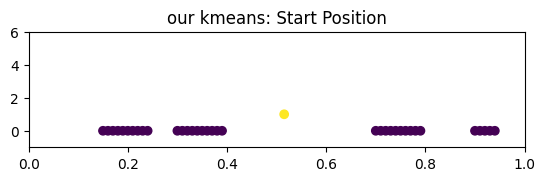

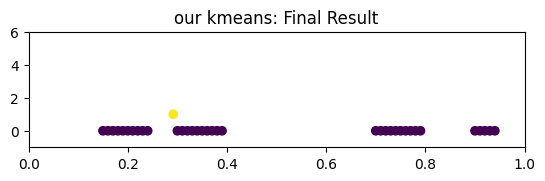

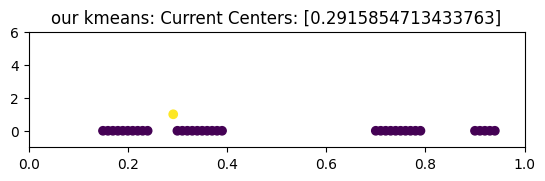

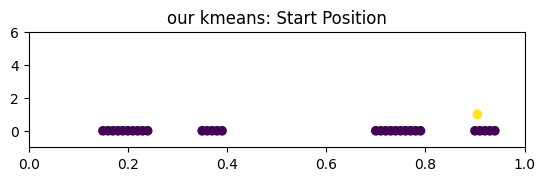

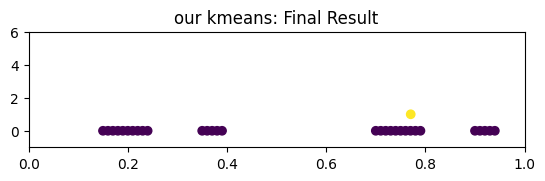

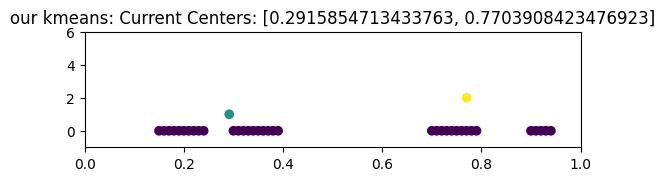

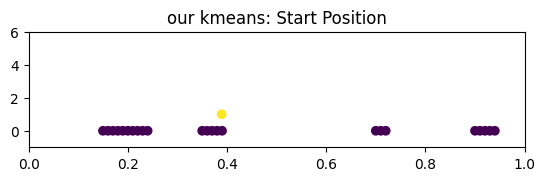

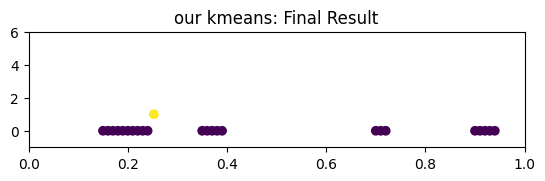

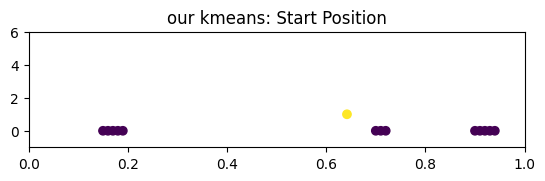

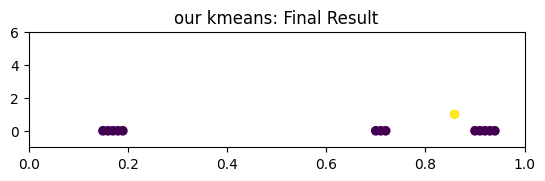

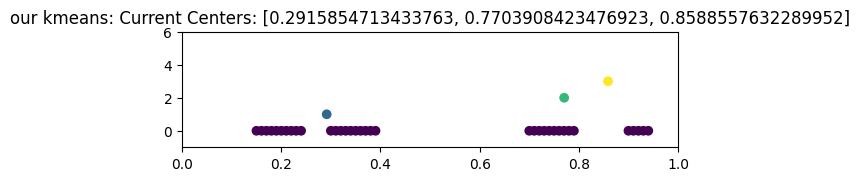

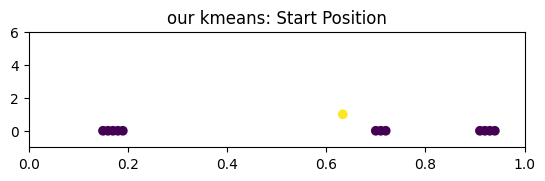

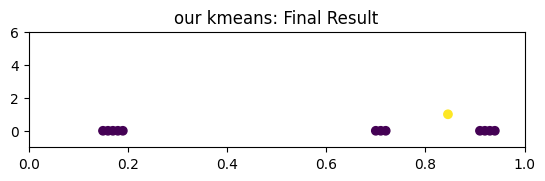

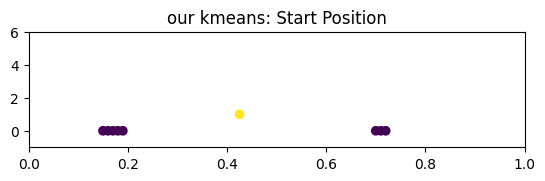

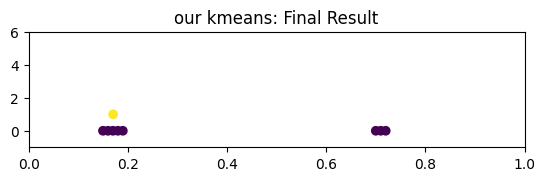

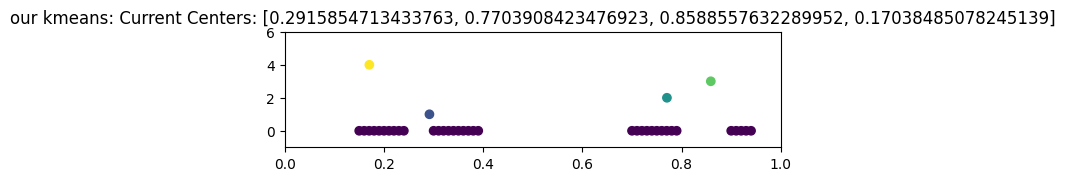

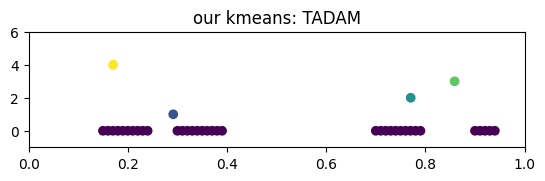

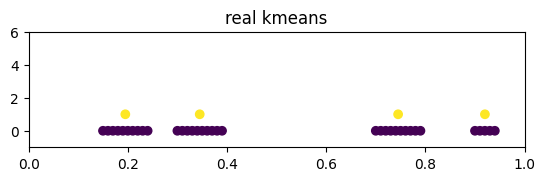

In [42]:
data = []
data.extend([x/100 for x in list(range(15,25))])
data.extend([x/100 for x in list(range(30,40))])
data.extend([x/100 for x in list(range(70,80))])
data.extend([x/100 for x in list(range(90,95))])
original_data = data.copy()


#variables
k = 4
n = 3
p = 3
iterations_for_center = 40
internal_iterations = 20
interval = 0.05
to_print = False
to_draw = False

discovered_centers = new_kmeans(data, k, n, p, iterations_for_center, internal_iterations, interval, to_print, to_draw)
#suggestion, run the same algorithm, but now data=discovered_centers

#fuzzy_c_means(k, (np.asarray(data)).reshape(1,-1))
real_kmeans(k, data)

#consider changing the order of current_interval *= 2 command before removing data
#TODO: intersection overlapping interval